Things to accomplish with NvTabular:
Multi hot encoding for genre list -- Create the embedding for the list to feed the transformer.
Create sequnces from the sessionid.
Trim the input that has less that two movies clicked.
Split the dataframe into train and test to get NDCGAt scores.
Create a schema (Captures the graphical relationship between the features)

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout patch-22.12
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

# Install the Merlin Framework
!pip install -U git+https://github.com/NVIDIA-Merlin/models.git


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 400, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 400 (delta 95), reused 52 (delta 51), pack-reused 269
Receiving objects: 100% (400/400), 109.76 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (197/197), done.
/content/rapidsai-csp-utils
error: pathspec 'patch-22.12' did not match any file(s) known to git
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 560.4 kB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip

In [ ]:
!pip install -U git+https://github.com/NVIDIA-Merlin/nvtabular.git
!pip install -U git+https://github.com/NVIDIA-Merlin/core.git
!pip install -U git+https://github.com/NVIDIA-Merlin/systems.git
!pip install -U git+https://github.com/NVIDIA-Merlin/dataloader.git
!pip install -U git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git
!pip install -U xgboost lightfm implicit

  Cloning https://github.com/NVIDIA-Merlin/nvtabular.git to /tmp/pip-req-build-q3ya5n9q
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/nvtabular.git /tmp/pip-req-build-q3ya5n9q
  Resolved https://github.com/NVIDIA-Merlin/nvtabular.git to commit 9f0ba3379333eb95fbb9222faa00ca1658a28a7f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvtabular: filename=nvtabular-23.8.0+2.g9f0ba337-cp310-cp310-linux_x86_64.whl size=248838 sha256=624b0312d2fcd952c1a755b79f8caa4f67e2f0e1ac6f1eab7af486e0d8128787
  Stored in directory: /tmp/pip-ephem-wheel-cache-2p4r1rri/wheels/3d/58/4d/cdb4b94f0b7c6c4c9962d0f68a7cdb25f9b00e6092e4bc785b
Successfully built nvtabular
  Cloning https://github.com/NVIDIA-Merlin/core.git to /tmp/pip-req-build-s29nhwrw
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/core.git /tmp/pip-req-build-s2

In [ ]:
import os

import numpy as np
import cupy as cp
import glob

import cudf
import nvtabular as nvt

from nvtabular.ops import Operator
from merlin.dag import ColumnSelector
from merlin.schema import Schema, Tags

In [ ]:
from numba import config
config.CUDA_LOW_OCCUPANCY_WARNINGS = 0

In [ ]:
df = cudf.read_parquet('/content/drive/MyDrive/output.parquet')

In [ ]:
print(df.head(5))

   user_id  movie_id  rating  unix_timestamp  \
0        1      3186       4       978300019   
1        1      1270       5       978300055   
2        1      1721       4       978300055   
3        1      1022       5       978300055   
4        1      2340       3       978300103   

                         genre_list  liked  Session_id  
0                           [Drama]      1           1  
1                  [Comedy, Sci-Fi]      1           1  
2                  [Drama, Romance]      1           1  
3  [Animation, Children's, Musical]      1           1  
4                         [Romance]      1           1  


In [ ]:
df.shape

(836477, 7)

In [ ]:
df.isnull().any()

user_id           False
movie_id          False
rating            False
unix_timestamp    False
genre_list        False
liked             False
Session_id        False
dtype: bool

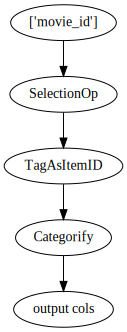

In [ ]:
movie_id = ['movie_id'] >> nvt.ops.TagAsItemID()>> nvt.ops.Categorify()
movie_id.graph
# cat_feats = item_id + ['genre_list'] >> nvt.ops.Categorify()

Ref: https://nvidia-merlin.github.io/NVTabular/main/api/ops/groupby.html groupby in nvTabular

Group by session id and create the sequential features.grouping the data by the session id. The data is already sorted based on the timestamp during preprocessing.

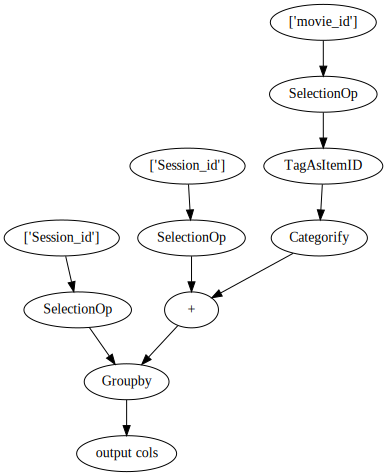

In [ ]:
feature_list = ['Session_id']+ movie_id
#initial test with only the sequence of movies.
groupby_features = feature_list >> nvt.ops.Groupby(groupby_cols=['Session_id'], aggs={'movie_id': 'list'})
groupby_features.graph
# workflow = nvt.Workflow(groupby_features)

In [ ]:
groupby_features_list = groupby_features['movie_id_list']

In [ ]:
SESSIONS_MAX_LENGTH = 20
MINIMUM_SESSION_LENGTH = 2

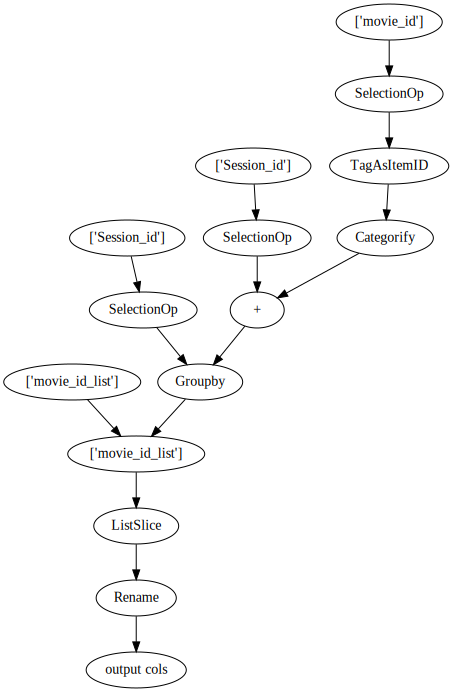

In [ ]:
groupby_features_trim = groupby_features_list >> nvt.ops.ListSlice(0,SESSIONS_MAX_LENGTH, pad = True) >> nvt.ops.Rename(postfix='_seq')
groupby_features_trim.graph

In [ ]:
sess_id = groupby_features['Session_id'] >> nvt.ops.AddMetadata(tags=[Tags.CATEGORICAL])
selected_features = sess_id + groupby_features_trim

In [ ]:
workflow = nvt.Workflow(groupby_features_trim)

In [ ]:
workflow.save("/content/drive/MyDrive/movie_rec_transformer/workflow_etl")

In [ ]:
num_sessions = len(df['Session_id'].unique())
print(num_sessions)

80902


In [ ]:
train = int(0.9 * num_sessions)
test = num_sessions- train
print(train)
print(test)

72811
8091


In [ ]:
train_indices= cudf.Series(cudf.core.index.RangeIndex(0, train))
print(train_indices)

0            0
1            1
2            2
3            3
4            4
         ...  
72806    72806
72807    72807
72808    72808
72809    72809
72810    72810
Length: 72811, dtype: int64


In [ ]:
train_df = df.take(train_indices)
test_df = df.drop(train_indices)
train_df = train_df[train_df['Session_id'] != 7019]

In [ ]:
train_df.head()

,user_id,movie_id,rating,unix_timestamp,genre_list,liked,Session_id
0,1,3186,4,978300019,[Drama],1,1
1,1,1270,5,978300055,"[Comedy, Sci-Fi]",1,1
2,1,1721,4,978300055,"[Drama, Romance]",1,1
3,1,1022,5,978300055,"[Animation, Children's, Musical]",1,1
4,1,2340,3,978300103,[Romance],1,1


In [ ]:
train_df.tail(20)

,user_id,movie_id,rating,unix_timestamp,genre_list,liked,Session_id
72790,564,1210,5,976039933,"[Action, Adventure, Romance, Sci-Fi, War]",1,7017
72791,564,2078,4,976039933,"[Animation, Children's, Comedy, Musical]",1,7017
72792,564,2023,3,976039980,"[Action, Crime, Drama]",1,7017
72793,564,2432,3,976039980,[Drama],1,7017
72794,564,1961,4,976040018,[Drama],1,7017
72795,564,2529,5,976040018,"[Action, Sci-Fi]",1,7017
72796,564,2339,3,976040018,"[Comedy, Romance]",1,7017
72797,564,3916,5,976040258,[Drama],1,7017
72798,564,3062,4,976040258,"[Action, Drama, War]",1,7017
72799,564,3217,4,976040358,[Drama],1,7017


In [ ]:
test_df.head()

,user_id,movie_id,rating,unix_timestamp,genre_list,liked,Session_id
72811,564,1204,5,976040575,"[Adventure, War]",1,7019
72812,564,1212,3,976040575,"[Mystery, Thriller]",1,7019
72813,564,3250,4,976040614,[Drama],1,7019
72814,564,1262,4,976040614,"[Adventure, War]",1,7019
72815,564,593,5,976040652,"[Drama, Thriller]",1,7019


In [ ]:
dataset = nvt.Dataset(df)
workflow.fit_transform(dataset).to_parquet(os.path.join('/content/drive/MyDrive/movie_rec_transformer', "total_nvt"))

In [ ]:
dataset = nvt.Dataset(train_df)
workflow.fit_transform(dataset).to_parquet(os.path.join('/content/drive/MyDrive/movie_rec_transformer', "train_nvt"))

In [ ]:
workflow.output_schema.column_names

['movie_id_list_seq']

In [ ]:
dataset = nvt.Dataset(test_df)
workflow.fit_transform(dataset).to_parquet(os.path.join('/content/drive/MyDrive/movie_rec_transformer', "test_nvt"))

In [ ]:
check_train_df = cudf.read_parquet('/content/drive/MyDrive/movie_rec_transformer/total_nvt/part_0.parquet')
check_train_df.head(5)

,movie_id_list_seq
0,"[703, 11, 86, 480, 960, 1730, 100, 81, 202, 41..."
1,"[620, 4, 42, 15, 154, 84, 7, 378, 1374, 270, 0..."
2,"[401, 477, 102, 194, 25, 400, 347, 69, 14, 247..."
3,"[583, 66, 843, 59, 51, 141, 490, 19, 308, 730,..."
4,"[2010, 18, 177, 667, 365, 97, 31, 46, 441, 834..."


In [ ]:
print(check_train_df.shape)

(80902, 1)


In [ ]:
import os
import glob

import torch
import transformers4rec.torch as tr
from transformers4rec.torch.ranking_metric import NDCGAt, RecallAt
from transformers4rec.torch.utils.examples_utils import wipe_memory

In [ ]:
from merlin.schema import Schema
from merlin.io import Dataset

train = Dataset('/content/drive/MyDrive/movie_rec_transformer/train_nvt/part_0.parquet', engine="parquet")
test = Dataset('/content/drive/MyDrive/movie_rec_transformer/test_nvt/part_0.parquet', engine="parquet")
total = Dataset('/content/drive/MyDrive/movie_rec_transformer/total_nvt/part_0.parquet', engine="parquet")
schema = total.schema
# schema = schema.select_by_name(['movie_id_list_seq'])

In [ ]:
from transformers.trainer_callback import TrainerCallback, EarlyStoppingCallback

In [ ]:
#Input
sequence_length, d_model = 20, 64
# Define input module to process tabular input-features and to prepare masked inputs
inputs= tr.TabularSequenceFeatures.from_schema(
    schema,
    max_sequence_length=sequence_length,
    d_output=d_model,
    masking="mlm",
)

In [ ]:
# Define XLNetConfig class and set default parameters for HF XLNet config
transformer_config = tr.XLNetConfig.build(
    d_model=d_model, n_head=4, n_layer=2, total_seq_length=sequence_length
)
# Define the model block including: inputs, masking, projection and transformer block.
body = tr.SequentialBlock(
    inputs, tr.MLPBlock([64]), tr.TransformerBlock(transformer_config, masking=inputs.masking)
)

# Define the head for to next item prediction task
head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True,
                              metrics=[NDCGAt(top_ks=[10, 20], labels_onehot=True),
                                       RecallAt(top_ks=[10, 20], labels_onehot=True)]),
)

# Get the end-to-end Model class
model = tr.Model(head)

In [ ]:
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer

#Set arguments for training
training_args = T4RecTrainingArguments(
            output_dir="./tmp",
            max_sequence_length=20,
            data_loader_engine='merlin',
            num_train_epochs=50,
            dataloader_drop_last=False,
            per_device_train_batch_size = 256,
            per_device_eval_batch_size = 32,
            gradient_accumulation_steps = 1,
            learning_rate=0.000666,
            report_to = [],
            logging_steps=50,
        )

In [ ]:
# Instantiate the T4Rec Trainer, which manages training and evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    schema=schema,
    compute_metrics=True,
)

In [ ]:
trainer.train_dataset_or_path = train

In [ ]:
trainer.reset_lr_scheduler()
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
50,7.915600
100,7.493100
150,7.415300
200,7.403400
250,7.404900
300,7.378600
350,7.377600
400,7.395800
450,7.380500
500,7.376000


TrainOutput(global_step=1400, training_loss=7.3359513854980465, metrics={'train_runtime': 31.6726, 'train_samples_per_second': 11315.789, 'train_steps_per_second': 44.202, 'total_flos': 0.0, 'train_loss': 7.3359513854980465})

In [ ]:
trainer.eval_dataset_or_path = test

In [ ]:
train_metrics = trainer.evaluate(metric_key_prefix='eval')
print('\n' + '*'*20 + '\n')
for key in sorted(train_metrics.keys()):
    print(" %s = %s" % (key, str(train_metrics[key])))


********************

 eval_/loss = 7.382091522216797
 eval_/next-item/ndcg_at_10 = 0.011631148867309093
 eval_/next-item/ndcg_at_20 = 0.017238914966583252
 eval_/next-item/recall_at_10 = 0.025431757792830467
 eval_/next-item/recall_at_20 = 0.047899410128593445
 eval_runtime = 24.937
 eval_samples_per_second = 2962.993
 eval_steps_per_second = 92.594


In [ ]:
model.save("/content/drive/MyDrive/movie_rec_transformer/saved_model")

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

Inferencing from the model

In [ ]:
import os
import torch
import cudf
from merlin.io import Dataset
from nvtabular import Workflow

from merlin.systems.dag import Ensemble
from merlin.systems.dag.ops.pytorch import PredictPyTorch
from merlin.systems.dag.ops.workflow import TransformWorkflow
from merlin.table import TensorTable, TorchColumn
from merlin.table.conversions import convert_col

In [ ]:
!pip install tritonclient[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 15.3 MB/s eta 0:00:00


In [ ]:
model_path= "/content/drive/MyDrive/movie_rec_transformer/saved_model"

In [ ]:
import cloudpickle
loaded_model = cloudpickle.load(
                open(os.path.join(model_path, "t4rec_model_class.pkl"), "rb")
            )

In [ ]:
from merlin.schema import Schema
from merlin.io import Dataset

train = Dataset("/content/drive/MyDrive/movie_rec_transformer/train_nvt/part_0.parquet")
schema = train.schema

In [ ]:
model = loaded_model.cuda()
model.eval()

Model(
  (heads): ModuleList(
    (0): Head(
      (body): SequentialBlock(
        (0): TabularSequenceFeatures(
          (to_merge): ModuleDict(
            (categorical_module): SequenceEmbeddingFeatures(
              (filter_features): FilterFeatures()
              (embedding_tables): ModuleDict(
                (movie_id_list_seq): Embedding(3631, 64, padding_idx=0)
              )
            )
            (pretrained_embedding_module): PretrainedEmbeddingFeatures(
              (filter_features): FilterFeatures()
            )
          )
          (_aggregation): ConcatFeatures()
          (projection_module): SequentialBlock(
            (0): DenseBlock(
              (0): Linear(in_features=64, out_features=64, bias=True)
              (1): ReLU(inplace=True)
            )
          )
          (_masking): MaskedLanguageModeling()
        )
        (1): SequentialBlock(
          (0): DenseBlock(
            (0): Linear(in_features=64, out_features=64, bias=True)
         

In [ ]:
dataset = train

In [ ]:
import pandas as pd
from merlin.table import TensorTable, TorchColumn
from merlin.table.conversions import convert_col

df = cudf.read_parquet("/content/drive/MyDrive/movie_rec_transformer/train_nvt/part_0.parquet", columns=model.input_schema.column_names)
table = TensorTable.from_df(df.loc[:100])
for column in table.columns:
    table[column] = convert_col(table[column], TorchColumn)
model_input_dict = table.to_dict()

In [ ]:

topk = 20
model.top_k = topk

In [ ]:
model.eval()
traced_model = torch.jit.trace(model, model_input_dict, strict=True)

In [ ]:
model_input_dict['movie_id_list_seq__values']

tensor([957,  21,  61,  ...,   0,   0,   0], device='cuda:0')

In [ ]:
input_schema = model.input_schema
output_schema = model.output_schema

In [ ]:
import shutil
ens_model_path = "/content/drive/MyDrive/movie_rec_transformer/models"
# Make sure we have a clean stats space for Dask
if os.path.isdir(ens_model_path):
    shutil.rmtree(ens_model_path)
os.mkdir(ens_model_path)

In [ ]:
# from nvtabular.workflow import Workflow
# workflow = Workflow.load("/content/drive/MyDrive/movie_rec_transformer/workflow_etl")
print(workflow.input_schema.column_names)

['movie_id', 'Session_id']


In [ ]:
torch_op = workflow.input_schema.column_names >> TransformWorkflow(workflow) >> PredictPyTorch(
    traced_model, input_schema, output_schema
)

ensemble = Ensemble(torch_op, workflow.input_schema)

In [ ]:
ensemble = Ensemble(torch_op, workflow.input_schema)
ens_config, node_configs = ensemble.export(ens_model_path)

In [ ]:
ensemble.input_schema

,name,tags,dtype,is_list,is_ragged
0,movie_id,(),"DType(name='int64', element_type=<ElementType....",False,False
1,Session_id,(),"DType(name='int64', element_type=<ElementType....",False,False


In [ ]:
import tritonclient.http as client

# Create a triton client
try:
    triton_client = client.InferenceServerClient(url="localhost:8000", verbose=True)
    print("client created.")
except Exception as e:
    print("channel creation failed: " + str(e))

client created.


In [ ]:
# ensure triton is in a good state
triton_client.is_server_live()
triton_client.get_model_repository_index()

GET /v2/health/live, headers {}


ConnectionRefusedError: ignored